<a href="https://colab.research.google.com/github/bcury/Python-Projects/blob/main/AI_gen_MNISTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#gpu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 92310671.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122235816.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22695442.45it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24145156.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



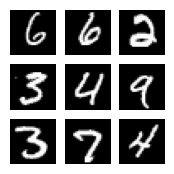

In [4]:
indices = random.sample(range(100), 9)
images = [mnist_data[i][0] for i in indices]

fig, axes = plt.subplots(3, 3, figsize=(2, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')

plt.show()

In [5]:
# Hipe parametros
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#pré-processamento
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataloader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True,
                    download=True, transform=transform), batch_size=batch_size, shuffle=True)

In [7]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)


In [8]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [9]:
generator = Generator().to(device)

discriminator = Discriminator().to(device)

In [10]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

[Epoch 10/100] [Avg D loss: 0.28431497004304107] [Avg G loss: 2.85639627579687]


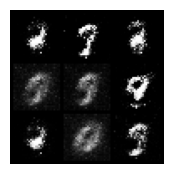

[Epoch 20/100] [Avg D loss: 0.3851913759893954] [Avg G loss: 1.979854424879241]


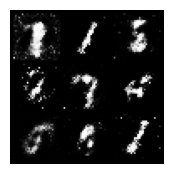

[Epoch 30/100] [Avg D loss: 0.4659227067981956] [Avg G loss: 1.603603383117139]


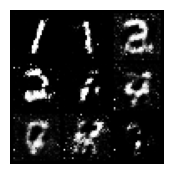

[Epoch 40/100] [Avg D loss: 0.5117247456680737] [Avg G loss: 1.387654031009308]


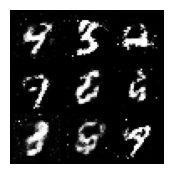

[Epoch 50/100] [Avg D loss: 0.5374242238906909] [Avg G loss: 1.2625918216796825]


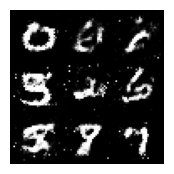

[Epoch 60/100] [Avg D loss: 0.5660877808578996] [Avg G loss: 1.1547381805458556]


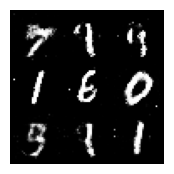

[Epoch 70/100] [Avg D loss: 0.582588507867317] [Avg G loss: 1.0894651991217883]


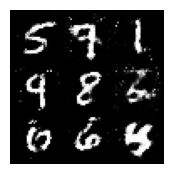

[Epoch 80/100] [Avg D loss: 0.5918943266243314] [Avg G loss: 1.0585539720968398]


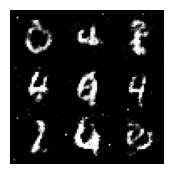

[Epoch 90/100] [Avg D loss: 0.6053619210018533] [Avg G loss: 1.0198083755049878]


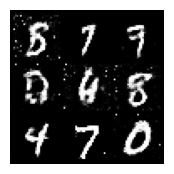

[Epoch 100/100] [Avg D loss: 0.6060284494336988] [Avg G loss: 1.0103474558035195]


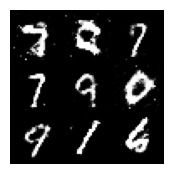

In [11]:
# Treinamento, percorre as epocs

for epoch in range(epochs):
    d_loss_accumulated = 0.0
    g_loss_accumulated = 0.0

    for i, (imgs, _) in enumerate(dataloader):
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Treinamento do Discriminator
        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        pred_real = discriminator(real_imgs)
        loss_real = criterion(pred_real, real)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        pred_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(pred_fake, fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        d_loss_accumulated += d_loss.item()

        # Treinamento do Generator
        optimizer_G.zero_grad()
        pred_fake = discriminator(fake_imgs)
        g_loss = criterion(pred_fake, real)
        g_loss.backward()
        optimizer_G.step()

        # Acumula a perda do Generator
        g_loss_accumulated += g_loss.item()

        # Se estiver no último batch da época e a época é um múltiplo de 10
        if i == len(dataloader) - 1 and (epoch + 1) % 10 == 0:
            d_loss_avg = d_loss_accumulated / len(dataloader)
            g_loss_avg = g_loss_accumulated / len(dataloader)

            print(f"[Epoch {epoch+1}/{epochs}] [Avg D loss: {d_loss_avg}] [Avg G loss: {g_loss_avg}]")

            grid = torchvision.utils.make_grid(fake_imgs.data[:9], nrow=3, normalize=True)
            grid_numpy = grid.permute(1, 2, 0).cpu().numpy()

            plt.figure(figsize=(2, 2))
            plt.imshow(grid_numpy)
            plt.axis('off')
            plt.show()
